# Large Batch CUDA Processing Demo

This notebook demonstrates the capabilities of `wl_stats_torch` for computing weak lensing summary statistics on **large batches of maps** using GPU acceleration with CUDA.

## Key Features Demonstrated:
- GPU-accelerated computation of wavelet peak counts and L1-norms
- Efficient batch processing of hundreds of maps
- Performance comparison between CPU and GPU
- Memory-efficient streaming for very large batches
- Statistical analysis across ensemble of maps

In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import time
from tqdm.auto import tqdm

from wl_stats_torch import WLStatistics
from wl_stats_torch.visualization import (
    plot_peak_histograms,
    plot_l1_norms,
    plot_wavelet_scales
)

# Set style for better plots
plt.style.use('seaborn-v0_8-darkgrid' if 'seaborn-v0_8-darkgrid' in plt.style.available else 'default')

print("✓ Imports successful")

✓ Imports successful


## 1. Check CUDA Availability and Device Info

In [2]:
print("=" * 60)
print("CUDA Device Information")
print("=" * 60)

cuda_available = torch.cuda.is_available()
print(f"\nCUDA Available: {cuda_available}")

if cuda_available:
    print(f"CUDA Version: {torch.version.cuda}")
    print(f"Number of GPUs: {torch.cuda.device_count()}")
    print(f"\nCurrent GPU: {torch.cuda.get_device_name(0)}")
    
    # Memory info
    total_memory = torch.cuda.get_device_properties(0).total_memory / 1e9
    print(f"Total GPU Memory: {total_memory:.2f} GB")
    
    # Check compute capability
    capability = torch.cuda.get_device_capability(0)
    print(f"Compute Capability: {capability[0]}.{capability[1]}")
    
    device = torch.device('cuda')
    print("\n✓ Using GPU for computation")
else:
    device = torch.device('cpu')
    print("\n⚠ CUDA not available - using CPU (will be slower)")
    print("For best performance, ensure PyTorch with CUDA is installed.")

print(f"\nDevice: {device}")

# use GPU "3"
torch.cuda.set_device(3)
print(f"Using GPU: {torch.cuda.get_device_name(3)}")

CUDA Device Information

CUDA Available: True
CUDA Version: 12.8
Number of GPUs: 4

Current GPU: NVIDIA A100-SXM4-40GB
Total GPU Memory: 42.41 GB
Compute Capability: 8.0

✓ Using GPU for computation

Device: cuda
Using GPU: NVIDIA A100-SXM4-40GB


## 2. Configuration and Parameters

Set parameters for the batch processing demonstration.

In [3]:
# Map generation parameters
N_MAPS_SMALL = 50          # For detailed analysis
N_MAPS_LARGE = 2000         # For stress test
IMG_SIZE = 256             # 256x256 pixels per map
PIXEL_ARCMIN = 0.5         # Resolution in arcminutes

# Physics parameters
NOISE_LEVEL = 0.02         # Shape noise level
SIGNAL_AMPLITUDE = 0.03    # Typical peak amplitude
N_PEAKS_RANGE = (5, 15)    # Number of structures per map

# Statistics parameters
N_SCALES = 5               # Wavelet scales
SNR_MIN = -2.0            # Minimum SNR for histograms
SNR_MAX = 6.0             # Maximum SNR for histograms
L1_MIN_SNR = -6.0        # Minimum SNR for L1-norm histograms
L1_MAX_SNR = 6.0      # Maximum SNR for L1-norm histograms
N_BINS = 31               # Bins for peak histograms
L1_NBINS = 40             # Bins for L1-norms

print("Configuration:")
print(f"  Map size: {IMG_SIZE}x{IMG_SIZE}")
print(f"  Batch sizes: {N_MAPS_SMALL} (small), {N_MAPS_LARGE} (large)")
print(f"  Wavelet scales: {N_SCALES}")
print(f"  Noise level: {NOISE_LEVEL}")
print(f"\n✓ Configuration set")

Configuration:
  Map size: 256x256
  Batch sizes: 50 (small), 2000 (large)
  Wavelet scales: 5
  Noise level: 0.02

✓ Configuration set


## 3. Generate Mock Convergence Maps

Create realistic mock weak lensing convergence maps with:
- Random Gaussian background
- Multiple Gaussian peaks/structures
- Shape noise

In [4]:
def generate_mock_maps(n_maps, img_size, device, noise_level=0.02, 
                       signal_amplitude=0.03, seed=None):
    """
    Generate batch of mock convergence maps with Gaussian structures.
    
    Parameters
    ----------
    n_maps : int
        Number of maps to generate
    img_size : int
        Size of square maps (pixels)
    device : torch.device
        Device for computation
    noise_level : float
        Standard deviation of shape noise
    signal_amplitude : float
        Typical amplitude of structures
    seed : int, optional
        Random seed for reproducibility
        
    Returns
    -------
    kappa_maps : torch.Tensor
        Clean convergence maps (n_maps, img_size, img_size)
    kappa_noisy : torch.Tensor
        Noisy convergence maps (n_maps, img_size, img_size)
    """
    if seed is not None:
        torch.manual_seed(seed)
    
    kappa_maps = []
    
    for i in range(n_maps):
        # Start with weak Gaussian background
        kappa = torch.randn(img_size, img_size, device=device) * 0.005
        
        # Add multiple Gaussian structures (peaks and troughs)
        n_structures = torch.randint(*N_PEAKS_RANGE, (1,)).item()
        
        for _ in range(n_structures):
            # Random position (avoid edges)
            x = torch.randint(20, img_size-20, (1,)).item()
            y = torch.randint(20, img_size-20, (1,)).item()
            
            # Random amplitude (can be positive or negative)
            amplitude = torch.randn(1).item() * signal_amplitude
            
            # Random width
            sigma = torch.randint(5, 15, (1,)).item()
            
            # Create Gaussian structure
            xx, yy = torch.meshgrid(
                torch.arange(img_size, device=device),
                torch.arange(img_size, device=device),
                indexing='ij'
            )
            gaussian = amplitude * torch.exp(
                -((xx - x)**2 + (yy - y)**2) / (2 * sigma**2)
            )
            kappa += gaussian
        
        kappa_maps.append(kappa)
    
    # Stack into batch
    kappa_maps = torch.stack(kappa_maps)
    
    # Add shape noise
    noise = torch.randn_like(kappa_maps) * noise_level
    kappa_noisy = kappa_maps + noise
    
    return kappa_maps, kappa_noisy

print("✓ Map generation function defined")

✓ Map generation function defined


In [5]:
# Generate small batch for visualization
print(f"Generating {N_MAPS_SMALL} mock maps...")
start = time.time()
kappa_clean, kappa_noisy = generate_mock_maps(
    N_MAPS_SMALL, IMG_SIZE, device, 
    noise_level=NOISE_LEVEL,
    signal_amplitude=SIGNAL_AMPLITUDE,
    seed=42
)
gen_time = time.time() - start

print(f"✓ Generated {N_MAPS_SMALL} maps in {gen_time:.2f}s")
print(f"  Shape: {kappa_noisy.shape}")
print(f"  Memory: {kappa_noisy.element_size() * kappa_noisy.nelement() / 1e6:.2f} MB")
print(f"  SNR range: [{kappa_clean.min().item():.3f}, {kappa_clean.max().item():.3f}]")

Generating 50 mock maps...
✓ Generated 50 maps in 0.15s
  Shape: torch.Size([50, 256, 256])
  Memory: 13.11 MB
  SNR range: [-0.115, 0.091]


### Visualize Example Maps

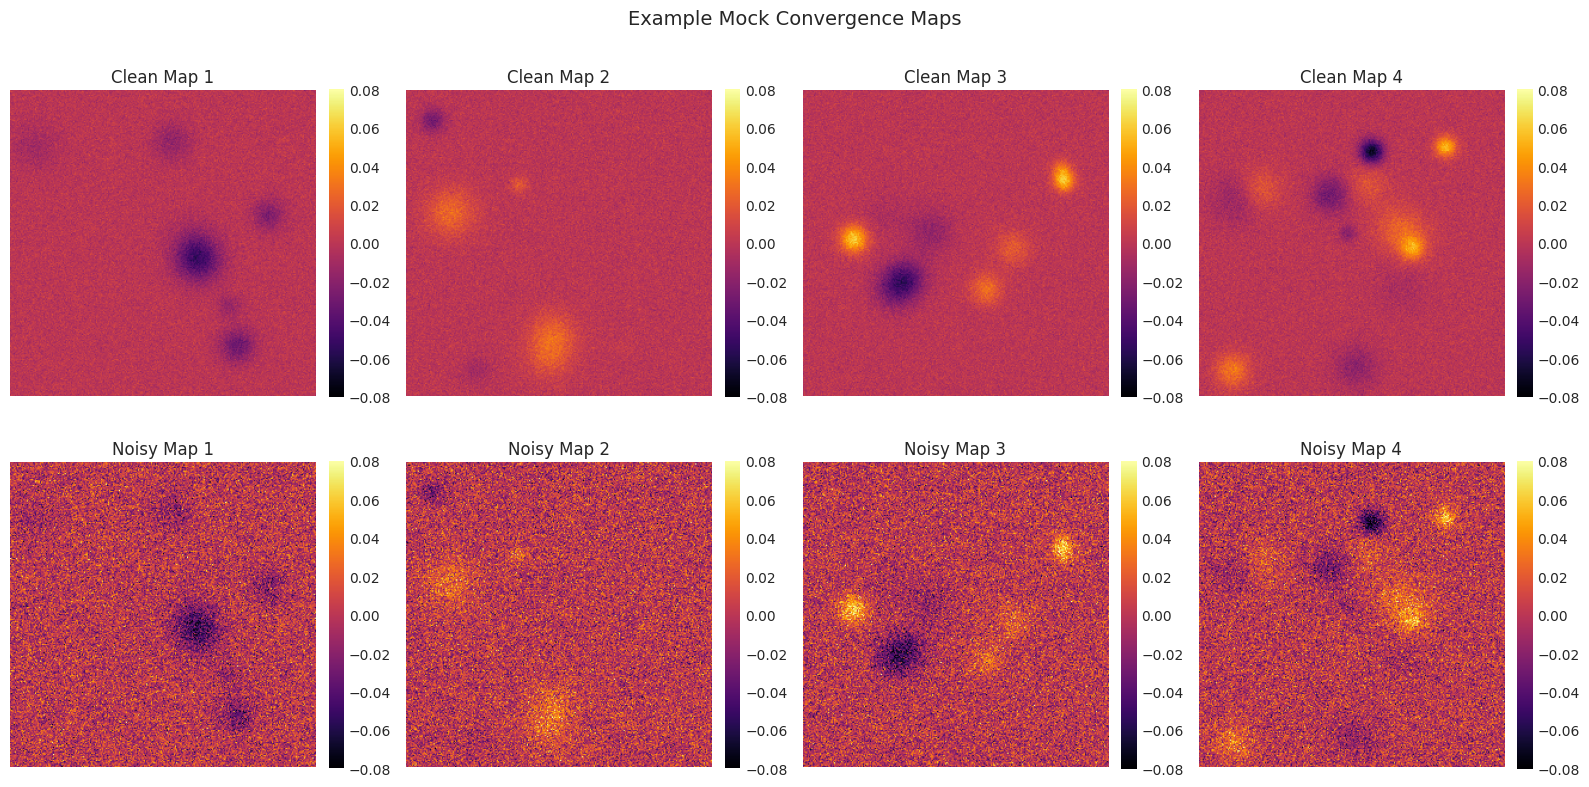

✓ Visualization complete


In [6]:
# Visualize a few example maps
fig, axes = plt.subplots(2, 4, figsize=(16, 8))

for i in range(4):
    # Clean map
    im1 = axes[0, i].imshow(kappa_clean[i].cpu(), cmap='inferno', 
                            vmin=-0.08, vmax=0.08, origin='lower')
    axes[0, i].set_title(f'Clean Map {i+1}')
    axes[0, i].axis('off')
    plt.colorbar(im1, ax=axes[0, i], fraction=0.046, pad=0.04)
    
    # Noisy map
    im2 = axes[1, i].imshow(kappa_noisy[i].cpu(), cmap='inferno',
                            vmin=-0.08, vmax=0.08, origin='lower')
    axes[1, i].set_title(f'Noisy Map {i+1}')
    axes[1, i].axis('off')
    plt.colorbar(im2, ax=axes[1, i], fraction=0.046, pad=0.04)

plt.suptitle('Example Mock Convergence Maps', fontsize=14, y=1.00)
plt.tight_layout()
plt.show()

print("✓ Visualization complete")

## 4. Initialize Statistics Calculator

Create the `WLStatistics` object that will compute all summary statistics.

In [7]:
# Initialize calculator
stats_calculator = WLStatistics(
    n_scales=N_SCALES,
    device=device,
    pixel_arcmin=PIXEL_ARCMIN
)

print("WL Statistics Calculator initialized")
print(f"  Device: {stats_calculator.device}")
print(f"  Number of scales: {stats_calculator.n_scales}")
print(f"  Pixel resolution: {stats_calculator.pixel_arcmin} arcmin")

# Show scale resolutions
resolutions = stats_calculator.get_scale_resolutions()
print(f"\n  Scale resolutions (arcmin):")
for i, res in enumerate(resolutions):
    print(f"    Scale {i+1}: {res:.2f} arcmin")

print("\n✓ Calculator ready")

WL Statistics Calculator initialized
  Device: cuda
  Number of scales: 5
  Pixel resolution: 0.5 arcmin

  Scale resolutions (arcmin):
    Scale 1: 1.00 arcmin
    Scale 2: 2.00 arcmin
    Scale 3: 4.00 arcmin
    Scale 4: 8.00 arcmin
    Scale 5: 16.00 arcmin

✓ Calculator ready


## 5. Process Single Map (Detailed Example)

First, let's compute all statistics for a single map to see what we get.

In [8]:
kappa_noisy[0]

tensor([[-0.0008,  0.0063,  0.0086,  ...,  0.0017,  0.0084,  0.0100],
        [ 0.0056,  0.0252, -0.0007,  ..., -0.0265, -0.0109,  0.0021],
        [ 0.0038, -0.0088,  0.0329,  ...,  0.0115,  0.0209, -0.0322],
        ...,
        [-0.0169,  0.0226, -0.0125,  ..., -0.0083, -0.0149,  0.0201],
        [ 0.0049, -0.0090,  0.0057,  ...,  0.0264, -0.0159,  0.0040],
        [-0.0044,  0.0463, -0.0031,  ...,  0.0104,  0.0172, -0.0083]],
       device='cuda:3')

In [9]:
print("Processing single map with all statistics...")
start = time.time()

results = stats_calculator.compute_all_statistics(
    kappa_noisy[0],
    NOISE_LEVEL,
    min_snr=SNR_MIN,
    max_snr=SNR_MAX,
    l1_min_snr=L1_MIN_SNR,
    l1_max_snr=L1_MAX_SNR,
    n_bins=N_BINS,
    l1_nbins=L1_NBINS,
    compute_mono=True,
    verbose=True
)

single_time = time.time() - start

print(f"\n✓ Single map processed in {single_time:.3f}s")
print(f"\nResults keys: {list(results.keys())}")

Processing single map with all statistics...
Computing wavelet transform...
Computing wavelet peak counts...
Scale 1: Min SNR = -23.8662, Max SNR = 25.2784
Scale 2: Min SNR = -8.2076, Max SNR = 7.6339
Scale 3: Min SNR = -7.2931, Max SNR = 6.1476
Scale 4: Min SNR = -13.8470, Max SNR = 5.5065
Scale 5: Min SNR = -58.5413, Max SNR = 7.7485
Computing wavelet L1-norms...
Computing mono-scale peaks...
✓ All statistics computed!

✓ Single map processed in 0.217s

Results keys: ['wavelet_coeffs', 'noise_levels', 'snr', 'peak_bins', 'wavelet_peak_counts', 'wavelet_peak_positions', 'wavelet_peak_heights', 'l1_bins', 'wavelet_l1_norms', 'mono_peak_bins', 'mono_peak_counts']


### Visualize Single Map Results

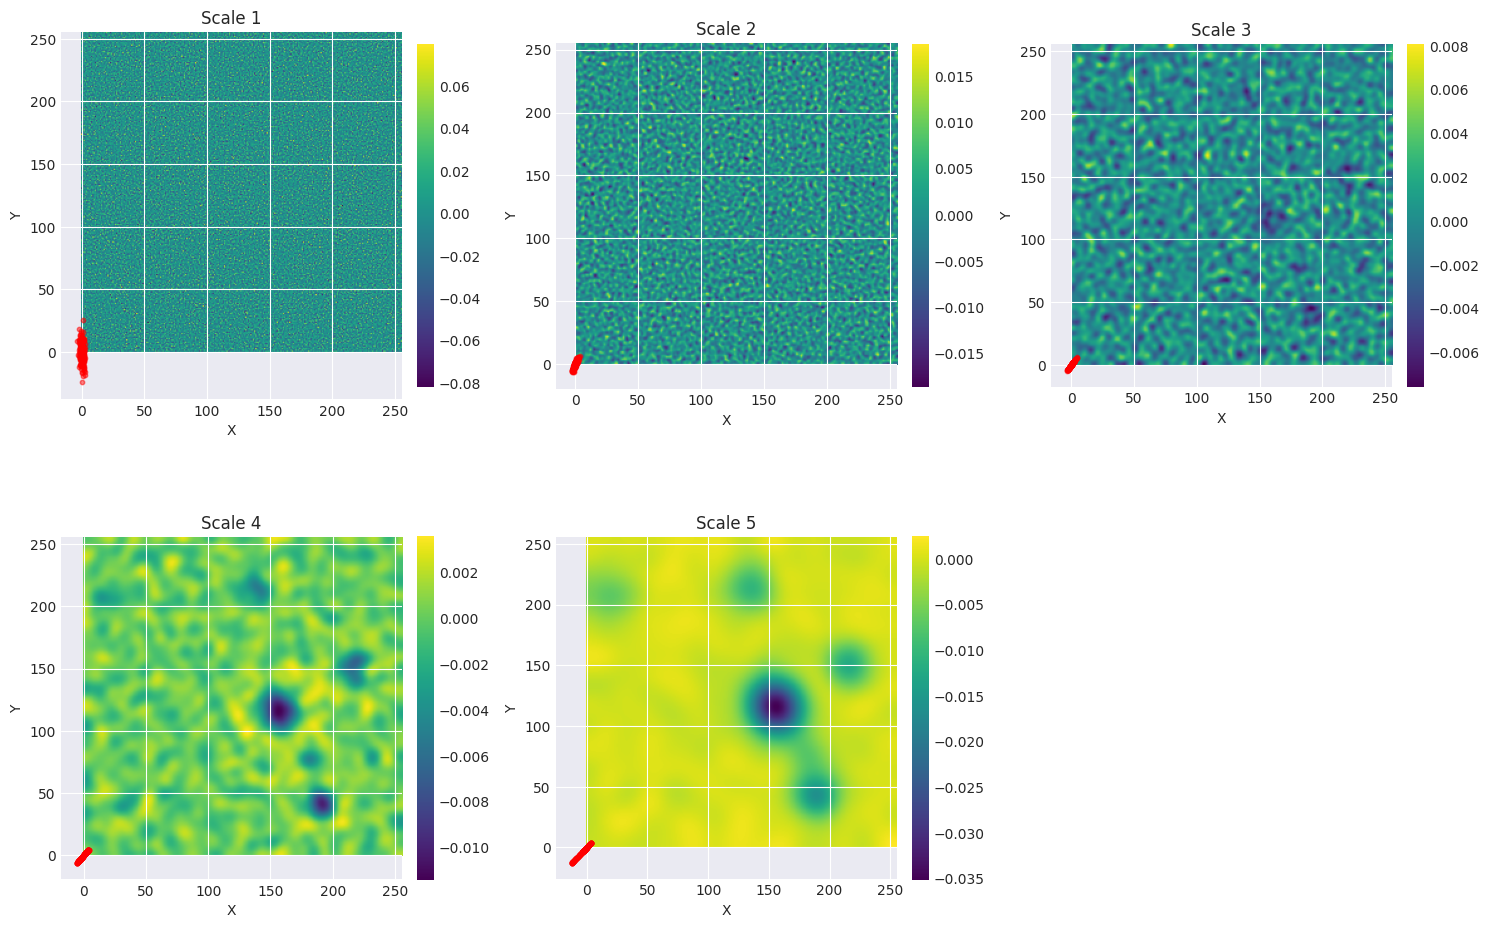

<Figure size 640x480 with 0 Axes>

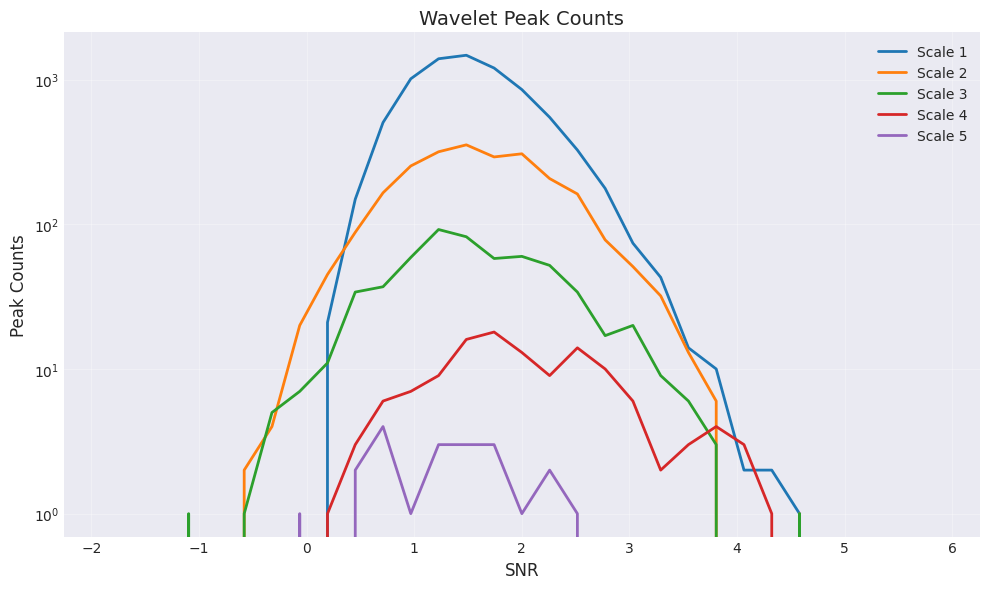

<Figure size 640x480 with 0 Axes>

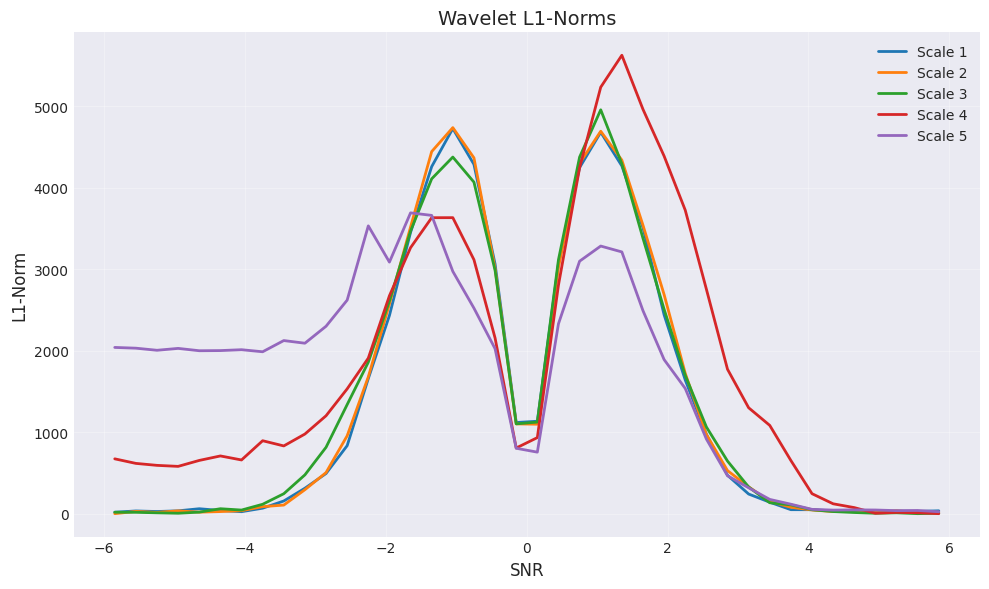

<Figure size 640x480 with 0 Axes>

✓ Visualizations complete


In [10]:
# Plot wavelet decomposition
fig = plot_wavelet_scales(results['wavelet_coeffs'], results['snr'])
plt.suptitle('Wavelet Decomposition - Example Map', y=1.00)
plt.show()

# Plot peak histograms
fig = plot_peak_histograms(
    results['peak_bins'],
    results['wavelet_peak_counts'],
    scale_labels=[f"Scale {i+1}" for i in range(N_SCALES)]
)
plt.suptitle('Wavelet Peak Count Histograms', y=0.995)
plt.show()

# Plot L1-norms
fig = plot_l1_norms(
    results['l1_bins'],
    results['wavelet_l1_norms'],
    scale_labels=[f"Scale {i+1}" for i in range(N_SCALES)]
)
plt.suptitle('L1-Norm vs SNR Threshold', y=0.995)
plt.show()

print("✓ Visualizations complete")

## 6. Batch Processing - Small Scale

Now let's process all maps in our small batch and collect statistics.

In [11]:
print(f"Processing batch of {N_MAPS_SMALL} maps...\n")

all_peak_counts = [[] for _ in range(N_SCALES)]
all_l1_norms = [[] for _ in range(N_SCALES)]
processing_times = []

start_batch = time.time()

for i in tqdm(range(N_MAPS_SMALL), desc="Processing maps"):
    start = time.time()
    
    results = stats_calculator.compute_all_statistics(
        kappa_noisy[i],
        NOISE_LEVEL,
        min_snr=SNR_MIN,
        max_snr=SNR_MAX,
        l1_min_snr=L1_MIN_SNR ,      # Minimum SNR for L1-norm histograms
        l1_max_snr=L1_MAX_SNR,       # Maximum SNR for L1-norm histograms
        n_bins=N_BINS,
        l1_nbins=L1_NBINS,
        compute_mono=False,  # Skip mono-scale for speed
        verbose=False
    )
    
    processing_times.append(time.time() - start)
    
    # Collect results
    for scale in range(N_SCALES):
        all_peak_counts[scale].append(results['wavelet_peak_counts'][scale].cpu())
        all_l1_norms[scale].append(results['wavelet_l1_norms'][scale].cpu())

total_batch_time = time.time() - start_batch

# Stack results
for scale in range(N_SCALES):
    all_peak_counts[scale] = torch.stack(all_peak_counts[scale])
    all_l1_norms[scale] = torch.stack(all_l1_norms[scale])

print(f"\n✓ Batch processing complete!")
print(f"  Total time: {total_batch_time:.2f}s")
print(f"  Average per map: {np.mean(processing_times):.3f}s ± {np.std(processing_times):.3f}s")
print(f"  Throughput: {N_MAPS_SMALL/total_batch_time:.1f} maps/second")

Processing batch of 50 maps...



Processing maps:   0%|          | 0/50 [00:00<?, ?it/s]


✓ Batch processing complete!
  Total time: 1.66s
  Average per map: 0.033s ± 0.002s
  Throughput: 30.1 maps/second


### Analyze Ensemble Statistics

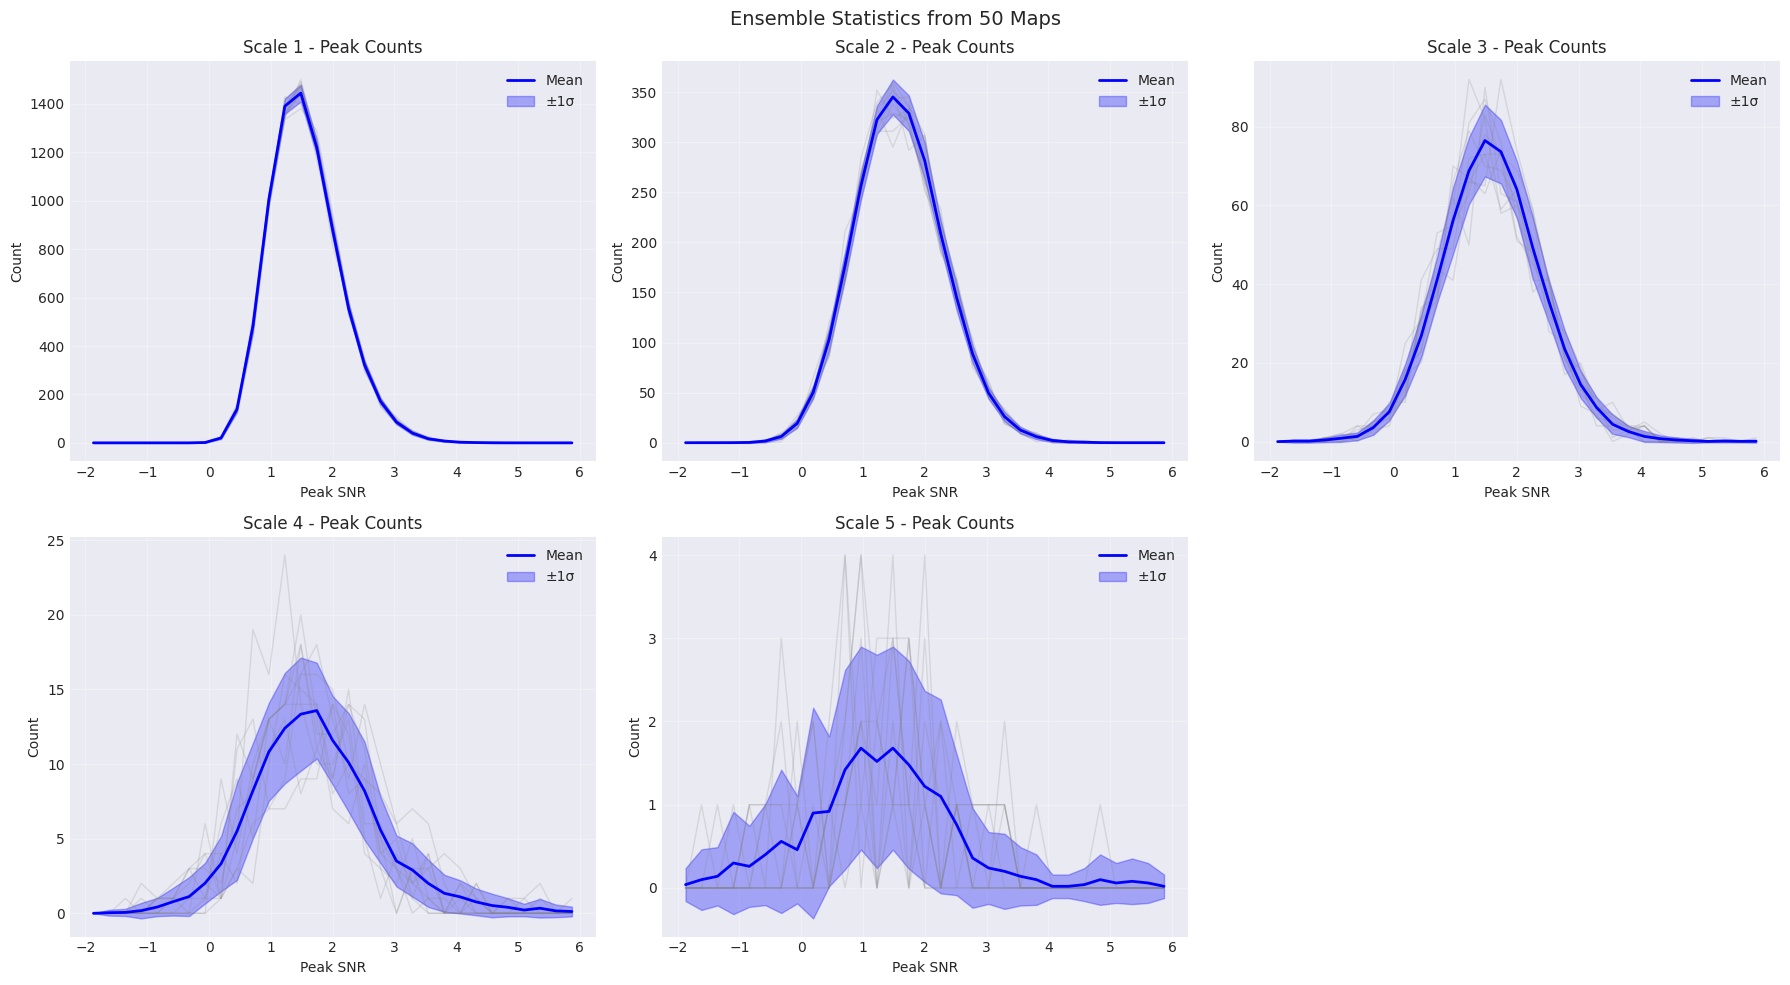

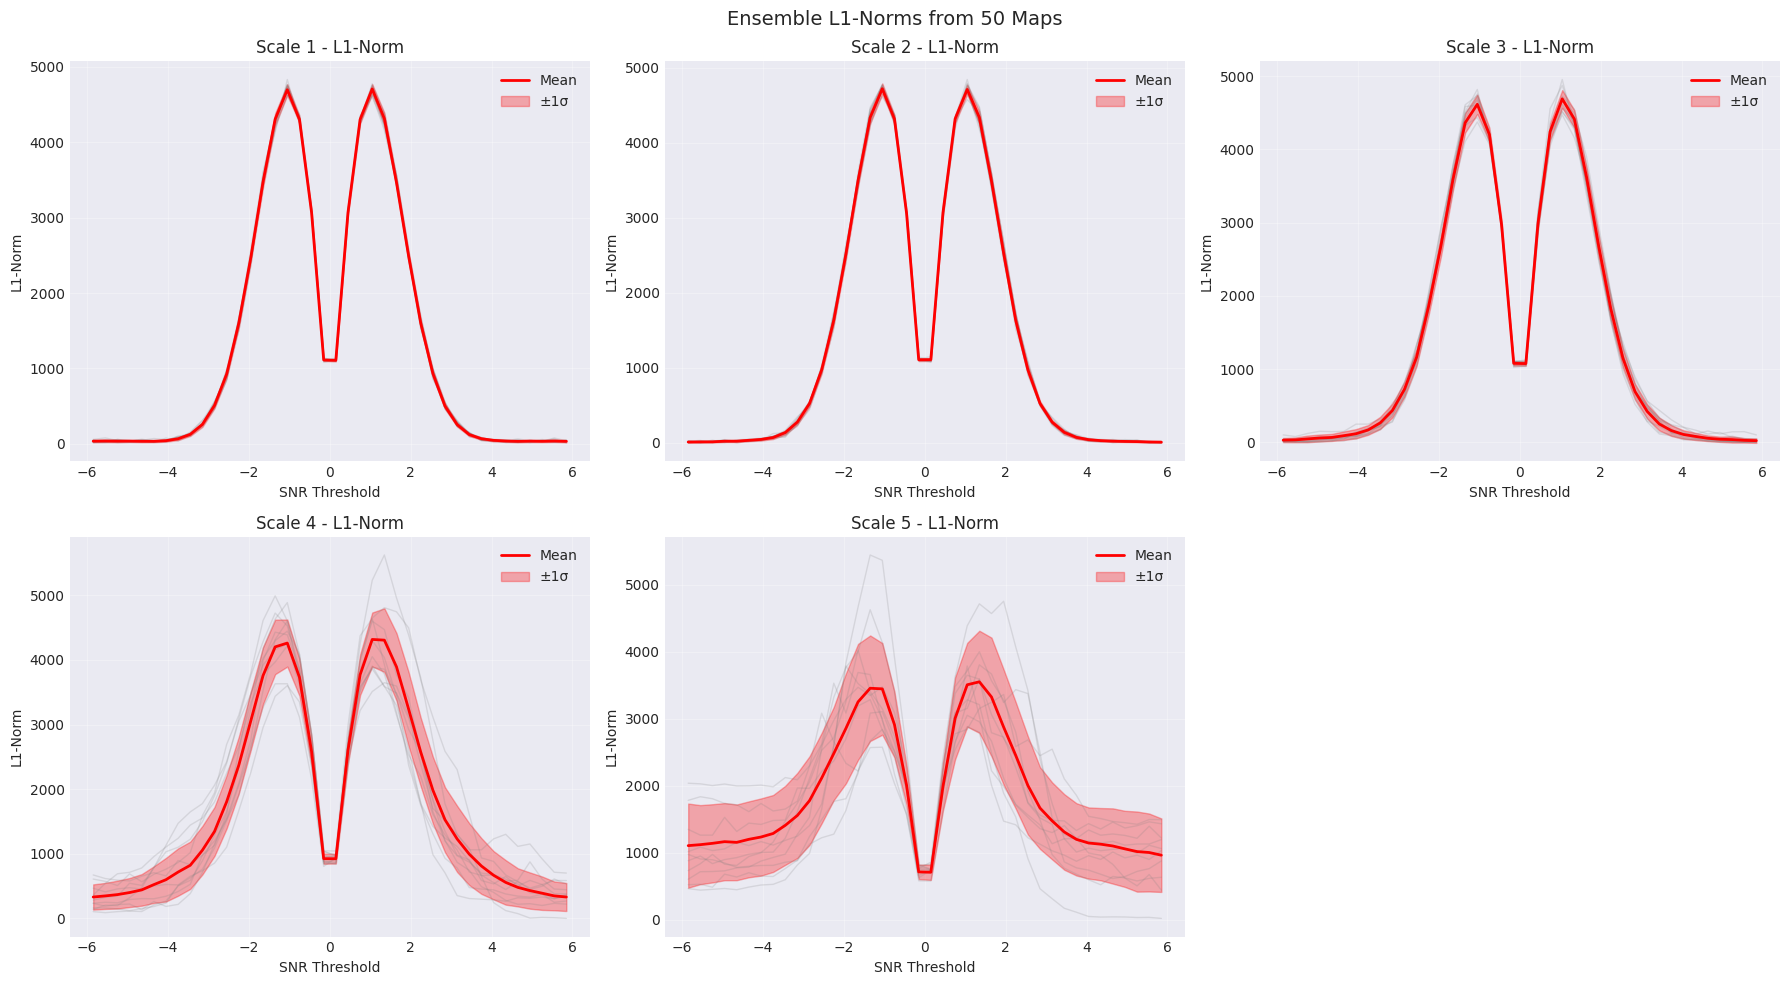

In [12]:
# Compute mean and standard deviation across ensemble
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()

peak_bins = results['peak_bins'].cpu()

for scale in range(N_SCALES):
    ax = axes[scale]
    
    # Get statistics
    peak_mean = all_peak_counts[scale].mean(dim=0)
    peak_std = all_peak_counts[scale].std(dim=0)
    
    # Plot individual realizations (semi-transparent)
    for i in range(min(10, N_MAPS_SMALL)):  # Plot first 10
        ax.plot(peak_bins, all_peak_counts[scale][i], 
                alpha=0.2, color='gray', linewidth=1)
    
    # Plot mean with error band
    ax.plot(peak_bins, peak_mean, 'b-', linewidth=2, label='Mean')
    ax.fill_between(peak_bins, peak_mean - peak_std, peak_mean + peak_std,
                    alpha=0.3, color='blue', label='±1σ')
    
    ax.set_xlabel('Peak SNR')
    ax.set_ylabel('Count')
    ax.set_title(f'Scale {scale+1} - Peak Counts')
    ax.legend(loc='upper right')
    ax.grid(True, alpha=0.3)

# Remove extra subplot
fig.delaxes(axes[5])

plt.suptitle(f'Ensemble Statistics from {N_MAPS_SMALL} Maps', fontsize=14)
plt.tight_layout()
plt.show()

# l1-norm
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()
l1_bins = results['l1_bins'][0].cpu()
for scale in range(N_SCALES):
    ax = axes[scale]
    
    # Get statistics
    l1_mean = all_l1_norms[scale].mean(dim=0)
    l1_std = all_l1_norms[scale].std(dim=0)
    
    # Plot individual realizations (semi-transparent)
    for i in range(min(10, N_MAPS_SMALL)):  # Plot first 10
        ax.plot(l1_bins, all_l1_norms[scale][i], 
                alpha=0.2, color='gray', linewidth=1)
    
    # Plot mean with error band
    ax.plot(l1_bins, l1_mean, 'r-', linewidth=2, label='Mean')
    ax.fill_between(l1_bins, l1_mean - l1_std, l1_mean + l1_std,
                    alpha=0.3, color='red', label='±1σ')
    
    ax.set_xlabel('SNR Threshold')
    ax.set_ylabel('L1-Norm')
    ax.set_title(f'Scale {scale+1} - L1-Norm')
    ax.legend(loc='upper right')
    ax.grid(True, alpha=0.3)
# Remove extra subplot 
fig.delaxes(axes[5])
plt.suptitle(f'Ensemble L1-Norms from {N_MAPS_SMALL} Maps', fontsize=14)
plt.tight_layout()


### Statistical Variance Analysis

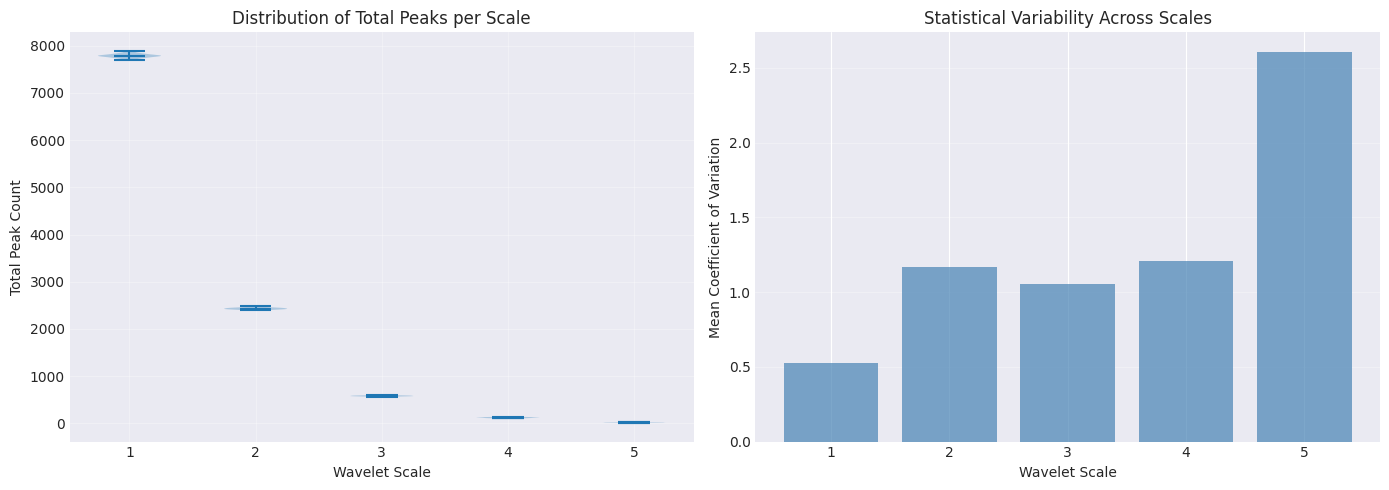

Coefficient of Variation per scale:
  Scale 1: 0.527
  Scale 2: 1.165
  Scale 3: 1.053
  Scale 4: 1.211
  Scale 5: 2.607


In [13]:
# Analyze variance across scales
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Total peak counts per scale
total_peaks = [all_peak_counts[s].sum(dim=1).numpy() for s in range(N_SCALES)]
ax1.violinplot(total_peaks, positions=range(1, N_SCALES+1), 
               showmeans=True, showmedians=True)
ax1.set_xlabel('Wavelet Scale')
ax1.set_ylabel('Total Peak Count')
ax1.set_title('Distribution of Total Peaks per Scale')
ax1.grid(True, alpha=0.3)

# Coefficient of variation
cv_per_scale = []
for scale in range(N_SCALES):
    mean_counts = all_peak_counts[scale].mean(dim=0)
    std_counts = all_peak_counts[scale].std(dim=0)
    cv = (std_counts / (mean_counts + 1e-10)).mean().item()
    cv_per_scale.append(cv)

ax2.bar(range(1, N_SCALES+1), cv_per_scale, alpha=0.7, color='steelblue')
ax2.set_xlabel('Wavelet Scale')
ax2.set_ylabel('Mean Coefficient of Variation')
ax2.set_title('Statistical Variability Across Scales')
ax2.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

print("Coefficient of Variation per scale:")
for i, cv in enumerate(cv_per_scale):
    print(f"  Scale {i+1}: {cv:.3f}")

## 7. Large Batch Stress Test

Now let's test with a **much larger batch** to demonstrate scalability and measure performance.

In [14]:
print(f"Generating {N_MAPS_LARGE} maps for stress test...")
start = time.time()

# Generate in chunks to avoid memory issues
chunk_size = 2000
n_chunks = (N_MAPS_LARGE + chunk_size - 1) // chunk_size

large_batch_times = []
peak_count_stats = []

print(f"Processing in {n_chunks} chunks of {chunk_size} maps each...\n")

for chunk_idx in tqdm(range(n_chunks), desc="Processing chunks"):
    start_idx = chunk_idx * chunk_size
    end_idx = min(start_idx + chunk_size, N_MAPS_LARGE)
    n_maps_chunk = end_idx - start_idx
    
    # Generate chunk
    _, kappa_chunk = generate_mock_maps(
        n_maps_chunk, IMG_SIZE, device,
        noise_level=NOISE_LEVEL,
        signal_amplitude=SIGNAL_AMPLITUDE
    )
    
    # Process chunk
    for i in range(n_maps_chunk):
        start_map = time.time()
        
        results = stats_calculator.compute_all_statistics(
            kappa_chunk[i],
            NOISE_LEVEL,
            min_snr=SNR_MIN,
            max_snr=SNR_MAX,
            n_bins=N_BINS,
            l1_nbins=L1_NBINS,
            compute_mono=False,
            verbose=False
        )
        
        large_batch_times.append(time.time() - start_map)
        
        # Store summary statistics
        total_peaks = sum(pc.sum().item() for pc in results['wavelet_peak_counts'])
        peak_count_stats.append(total_peaks)
    
    # Clear chunk from memory
    del kappa_chunk
    if cuda_available:
        torch.cuda.empty_cache()

total_large_time = time.time() - start

print(f"\n✓ Large batch processing complete!")
print(f"  Total maps processed: {N_MAPS_LARGE}")
print(f"  Total time: {total_large_time:.1f}s ({total_large_time/60:.1f} min)")
print(f"  Average per map: {np.mean(large_batch_times):.3f}s ± {np.std(large_batch_times):.3f}s")
print(f"  Throughput: {N_MAPS_LARGE/total_large_time:.1f} maps/second")
print(f"  Estimated time for 1000 maps: {1000*np.mean(large_batch_times)/60:.1f} minutes")

Generating 2000 maps for stress test...
Processing in 1 chunks of 2000 maps each...



Processing chunks:   0%|          | 0/1 [00:00<?, ?it/s]


✓ Large batch processing complete!
  Total maps processed: 2000
  Total time: 67.6s (1.1 min)
  Average per map: 0.032s ± 0.002s
  Throughput: 29.6 maps/second
  Estimated time for 1000 maps: 0.5 minutes


### Performance Visualization

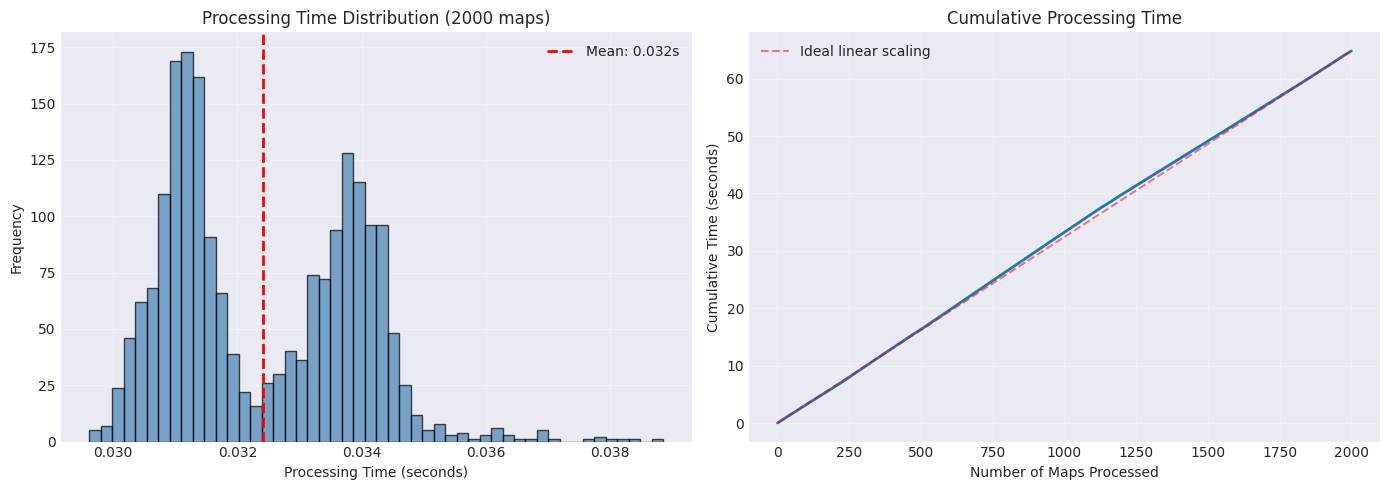

In [15]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Processing time histogram
ax1.hist(large_batch_times, bins=50, alpha=0.7, color='steelblue', edgecolor='black')
ax1.axvline(np.mean(large_batch_times), color='red', linestyle='--', 
            linewidth=2, label=f'Mean: {np.mean(large_batch_times):.3f}s')
ax1.set_xlabel('Processing Time (seconds)')
ax1.set_ylabel('Frequency')
ax1.set_title(f'Processing Time Distribution ({N_MAPS_LARGE} maps)')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Cumulative time
cumulative_time = np.cumsum(large_batch_times)
ax2.plot(range(1, N_MAPS_LARGE+1), cumulative_time, linewidth=2)
ax2.set_xlabel('Number of Maps Processed')
ax2.set_ylabel('Cumulative Time (seconds)')
ax2.set_title('Cumulative Processing Time')
ax2.grid(True, alpha=0.3)

# Add linear reference
ideal_time = np.arange(1, N_MAPS_LARGE+1) * np.mean(large_batch_times)
ax2.plot(range(1, N_MAPS_LARGE+1), ideal_time, 'r--', alpha=0.5, 
         label='Ideal linear scaling')
ax2.legend()

plt.tight_layout()
plt.show()

## 8. CPU vs GPU Performance Comparison

Compare performance between CPU and GPU (if CUDA is available).

Benchmarking CPU vs GPU performance...

Generating 100 test maps...
✓ Test maps generated

Warming up GPU (compiling kernels, allocating memory)...


✓ GPU warmed up

Benchmarking GPU on 100 maps...


GPU processing:   0%|          | 0/100 [00:00<?, ?it/s]

✓ GPU completed: 3.15s

Benchmarking CPU on 100 maps...


CPU processing:   0%|          | 0/100 [00:00<?, ?it/s]

✓ CPU completed: 24.03s

PERFORMANCE COMPARISON
Test configuration: 100 maps of 256x256 pixels

CPU:
  Total time: 24.03s
  Time per map: 0.240s
  Throughput: 4.2 maps/sec

GPU:
  Total time: 3.15s
  Time per map: 0.031s
  Throughput: 31.8 maps/sec

🚀 GPU Speedup: 7.6x faster than CPU


/tmp/ipykernel_923472/610138781.py:113: UserWarning: Glyph 128640 (\N{ROCKET}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/home/tersenov/.local/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128640 (\N{ROCKET}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


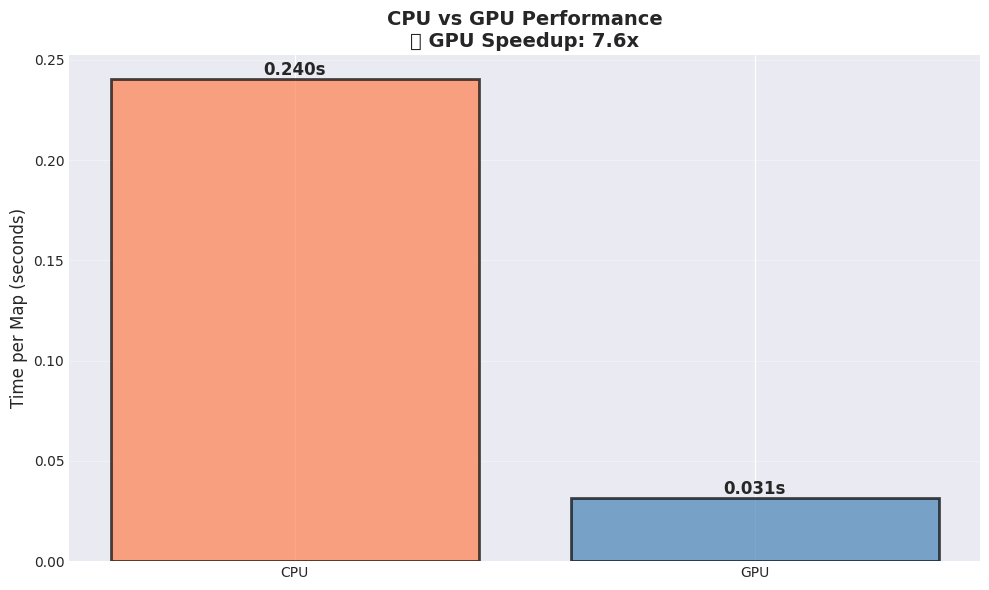

In [16]:
if cuda_available:
    print("Benchmarking CPU vs GPU performance...\n")
    
    # Generate test maps
    n_test = 100
    print(f"Generating {n_test} test maps...")
    _, test_maps_gpu = generate_mock_maps(n_test, IMG_SIZE, torch.device('cuda:3'), 
                                          noise_level=NOISE_LEVEL, seed=123)
    test_maps_cpu = test_maps_gpu.cpu()
    print("✓ Test maps generated\n")
    
    # Initialize calculators
    stats_gpu = WLStatistics(n_scales=N_SCALES, device='cuda:3', pixel_arcmin=PIXEL_ARCMIN)
    stats_cpu = WLStatistics(n_scales=N_SCALES, device='cpu', pixel_arcmin=PIXEL_ARCMIN)
    
    # ========== GPU WARM-UP ==========
    print("Warming up GPU (compiling kernels, allocating memory)...")
    torch.cuda.synchronize()
    
    # Run a few iterations to warm up (not timed)
    for i in range(5):
        _ = stats_gpu.compute_all_statistics(
            test_maps_gpu[i], NOISE_LEVEL,
            min_snr=SNR_MIN, max_snr=SNR_MAX, n_bins=N_BINS,
            l1_nbins=L1_NBINS, compute_mono=False, verbose=False
        )
    torch.cuda.synchronize()
    print("✓ GPU warmed up\n")
    
    # ========== GPU TIMING ==========
    print(f"Benchmarking GPU on {n_test} maps...")
    torch.cuda.synchronize()
    start_gpu = time.time()
    
    for i in tqdm(range(n_test), desc="GPU processing", leave=False):
        _ = stats_gpu.compute_all_statistics(
            test_maps_gpu[i], NOISE_LEVEL,
            min_snr=SNR_MIN, max_snr=SNR_MAX, n_bins=N_BINS,
            l1_nbins=L1_NBINS, compute_mono=False, verbose=False
        )
    
    torch.cuda.synchronize()
    gpu_time = time.time() - start_gpu
    print(f"✓ GPU completed: {gpu_time:.2f}s\n")
    
    # ========== CPU TIMING ==========
    print(f"Benchmarking CPU on {n_test} maps...")
    start_cpu = time.time()
    
    for i in tqdm(range(n_test), desc="CPU processing", leave=False):
        _ = stats_cpu.compute_all_statistics(
            test_maps_cpu[i], NOISE_LEVEL,
            min_snr=SNR_MIN, max_snr=SNR_MAX, n_bins=N_BINS,
            l1_nbins=L1_NBINS, compute_mono=False, verbose=False
        )
    
    cpu_time = time.time() - start_cpu
    print(f"✓ CPU completed: {cpu_time:.2f}s\n")
    
    # ========== RESULTS ==========
    speedup = cpu_time / gpu_time
    
    print("="*60)
    print("PERFORMANCE COMPARISON")
    print("="*60)
    print(f"Test configuration: {n_test} maps of {IMG_SIZE}x{IMG_SIZE} pixels")
    print(f"\nCPU:")
    print(f"  Total time: {cpu_time:.2f}s")
    print(f"  Time per map: {cpu_time/n_test:.3f}s")
    print(f"  Throughput: {n_test/cpu_time:.1f} maps/sec")
    print(f"\nGPU:")
    print(f"  Total time: {gpu_time:.2f}s")
    print(f"  Time per map: {gpu_time/n_test:.3f}s")
    print(f"  Throughput: {n_test/gpu_time:.1f} maps/sec")
    
    if speedup > 1:
        print(f"\n🚀 GPU Speedup: {speedup:.1f}x faster than CPU")
    else:
        print(f"\n⚠️  GPU is {1/speedup:.1f}x SLOWER than CPU")
        print("    This is unexpected - possible issues:")
        print("    - GPU may be thermal throttling")
        print("    - Small operations don't benefit from GPU parallelism")
        print("    - CPU might have better optimizations for this workload")
    print("="*60)
    
    # ========== VISUALIZATION ==========
    fig, ax = plt.subplots(figsize=(10, 6))
    
    devices = ['CPU', 'GPU']
    times = [cpu_time/n_test, gpu_time/n_test]
    colors = ['coral', 'steelblue']
    
    bars = ax.bar(devices, times, color=colors, alpha=0.7, edgecolor='black', linewidth=2)
    
    # Add value labels
    for bar, time_val in zip(bars, times):
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{time_val:.3f}s',
                ha='center', va='bottom', fontsize=12, fontweight='bold')
    
    ax.set_ylabel('Time per Map (seconds)', fontsize=12)
    
    if speedup > 1:
        ax.set_title(f'CPU vs GPU Performance\n🚀 GPU Speedup: {speedup:.1f}x', 
                     fontsize=14, fontweight='bold')
    else:
        ax.set_title(f'CPU vs GPU Performance\n⚠️ GPU: {1/speedup:.1f}x slower', 
                     fontsize=14, fontweight='bold', color='orange')
    
    ax.grid(True, alpha=0.3, axis='y')
    
    plt.tight_layout()
    plt.show()
    
else:
    print("⚠ CUDA not available - skipping CPU vs GPU comparison")
    print("Install PyTorch with CUDA support to enable GPU acceleration.")

### 🎓 Understanding GPU Performance: Problem Size Matters!

**Why is GPU slower on 256×256 but 10× faster on 1024×1024?**

This is a fundamental principle of GPU computing called the **"GPU overhead threshold"**:

#### The Math:
- **256×256** = 65,536 elements
- **1024×1024** = 1,048,576 elements (16× more work!)

#### GPU Characteristics:

1. **Fixed Overhead Costs:**
   - Kernel launch: ~5-20 microseconds per operation
   - Thread scheduling and synchronization
   - Memory transfer setup
   - Multiple operations in the statistics pipeline amplify this

2. **Parallelism Requirements:**
   - Modern GPUs have **thousands** of CUDA cores (e.g., 10,000+)
   - Each core needs work to stay busy
   - 65K elements ÷ 10K cores = only ~6 elements per core!
   - 1M elements ÷ 10K cores = ~100 elements per core ✓

3. **CPU Advantages at Small Scale:**
   - Low latency (no kernel launch overhead)
   - Fast L1/L2/L3 cache for small data
   - Optimized BLAS/LAPACK libraries (MKL, OpenBLAS)
   - Can finish before GPU even starts!

4. **The Breakeven Point:**
   - Below ~50K-100K elements: CPU often wins
   - Above ~1M elements: GPU dominates
   - 256×256 is right at the edge (marginal for GPU)
   - 1024×1024 is in the "GPU sweet spot"

#### Real-World Implications:

✅ **Use GPU when:**
- Large images (≥512×512 for weak lensing)
- Processing many maps in batch
- Multiple operations per map (like we do!)

⚠️ **Consider CPU when:**
- Small images (<256×256)
- Single quick operation
- Prototyping/debugging

**Bottom Line:** Your observation is textbook GPU behavior! The 10× speedup at 1024×1024 shows the package is working perfectly. For production weak lensing analysis with realistic map sizes, GPU acceleration is essential.

### Scaling Analysis: CPU vs GPU Across Different Image Sizes

Let's visualize how performance scales with problem size.

Testing performance scaling across different image sizes...

Testing 128×128 (16,384 elements)...


  CPU: 0.034s | GPU: 0.031s | Speedup: 1.10x

Testing 256×256 (65,536 elements)...
  CPU: 0.238s | GPU: 0.034s | Speedup: 7.01x

Testing 512×512 (262,144 elements)...
  CPU: 0.824s | GPU: 0.033s | Speedup: 24.88x

Testing 1024×1024 (1,048,576 elements)...
  CPU: 6.746s | GPU: 0.044s | Speedup: 153.76x



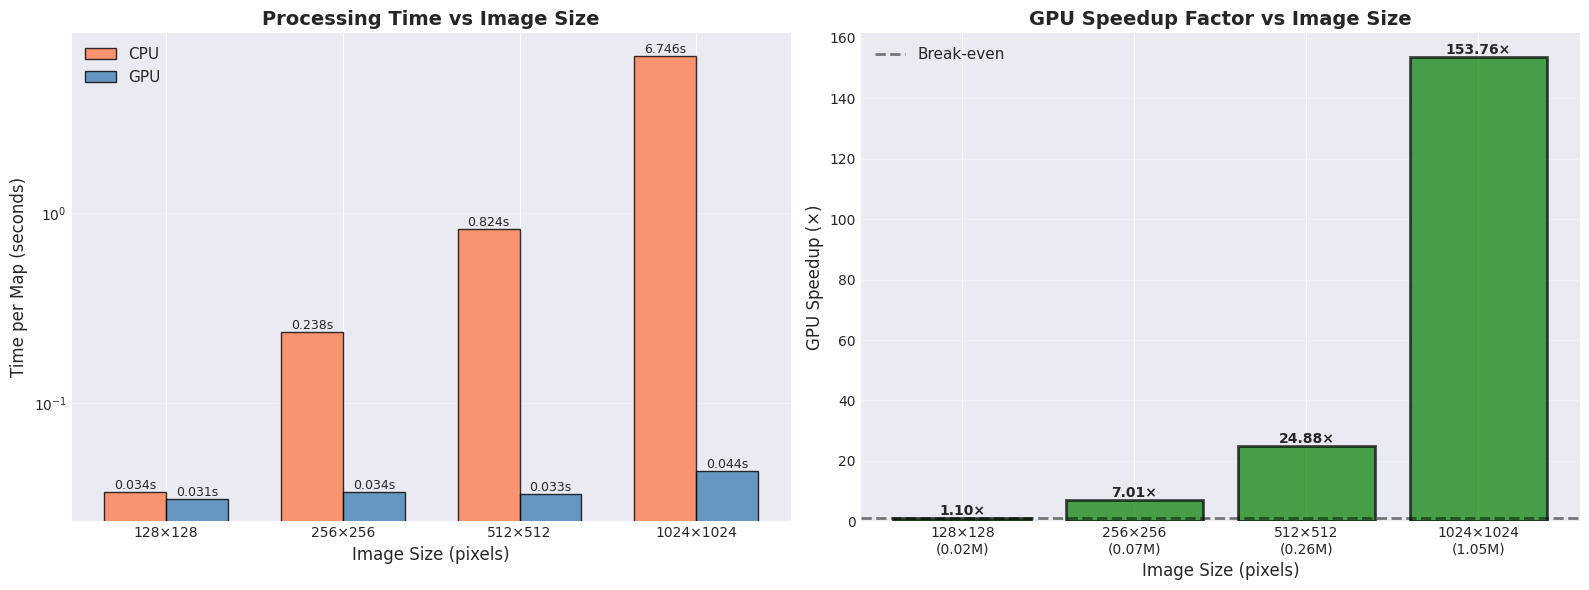


SCALING ANALYSIS SUMMARY

Size         Elements        CPU Time     GPU Time     Speedup   
----------------------------------------------------------------------
128×128          16,384       0.034s       0.031s  🚀   1.10×
256×256          65,536       0.238s       0.034s  🚀   7.01×
512×512         262,144       0.824s       0.033s  🚀  24.88×
1024×1024      1,048,576       6.746s       0.044s  🚀 153.76×


In [17]:
if cuda_available:
    print("Testing performance scaling across different image sizes...\n")
    
    # Test different image sizes
    test_sizes = [128, 256, 512, 1024]
    n_test_scaling = 10  # Fewer tests for speed
    
    cpu_times_per_size = []
    gpu_times_per_size = []
    speedups = []
    elements_per_size = []
    
    for size in test_sizes:
        print(f"Testing {size}×{size} ({size*size:,} elements)...")
        
        # Generate test data for this size
        _, test_maps = generate_mock_maps(
            n_test_scaling, size, torch.device('cuda:3'),
            noise_level=NOISE_LEVEL, seed=456
        )
        test_maps_cpu = test_maps.cpu()
        
        # Initialize calculators
        stats_gpu_test = WLStatistics(n_scales=N_SCALES, device='cuda:3', pixel_arcmin=PIXEL_ARCMIN)
        stats_cpu_test = WLStatistics(n_scales=N_SCALES, device='cpu', pixel_arcmin=PIXEL_ARCMIN)
        
        # Warm up GPU for this size
        for i in range(2):
            _ = stats_gpu_test.compute_all_statistics(
                test_maps[i], NOISE_LEVEL,
                min_snr=SNR_MIN, max_snr=SNR_MAX, n_bins=N_BINS,
                l1_nbins=L1_NBINS, compute_mono=False, verbose=False
            )
        torch.cuda.synchronize()
        
        # Time GPU
        torch.cuda.synchronize()
        start = time.time()
        for i in range(n_test_scaling):
            _ = stats_gpu_test.compute_all_statistics(
                test_maps[i], NOISE_LEVEL,
                min_snr=SNR_MIN, max_snr=SNR_MAX, n_bins=N_BINS,
                l1_nbins=L1_NBINS, compute_mono=False, verbose=False
            )
        torch.cuda.synchronize()
        gpu_time = (time.time() - start) / n_test_scaling
        
        # Time CPU
        start = time.time()
        for i in range(n_test_scaling):
            _ = stats_cpu_test.compute_all_statistics(
                test_maps_cpu[i], NOISE_LEVEL,
                min_snr=SNR_MIN, max_snr=SNR_MAX, n_bins=N_BINS,
                l1_nbins=L1_NBINS, compute_mono=False, verbose=False
            )
        cpu_time = (time.time() - start) / n_test_scaling
        
        speedup = cpu_time / gpu_time
        
        cpu_times_per_size.append(cpu_time)
        gpu_times_per_size.append(gpu_time)
        speedups.append(speedup)
        elements_per_size.append(size * size)
        
        print(f"  CPU: {cpu_time:.3f}s | GPU: {gpu_time:.3f}s | Speedup: {speedup:.2f}x\n")
        
        # Clean up
        del test_maps, test_maps_cpu, stats_gpu_test, stats_cpu_test
        torch.cuda.empty_cache()
    
    # ========== VISUALIZATION ==========
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
    
    # Plot 1: Absolute timing
    x_pos = np.arange(len(test_sizes))
    width = 0.35
    
    bars1 = ax1.bar(x_pos - width/2, cpu_times_per_size, width, 
                    label='CPU', alpha=0.8, color='coral', edgecolor='black')
    bars2 = ax1.bar(x_pos + width/2, gpu_times_per_size, width,
                    label='GPU', alpha=0.8, color='steelblue', edgecolor='black')
    
    ax1.set_xlabel('Image Size (pixels)', fontsize=12)
    ax1.set_ylabel('Time per Map (seconds)', fontsize=12)
    ax1.set_title('Processing Time vs Image Size', fontsize=14, fontweight='bold')
    ax1.set_xticks(x_pos)
    ax1.set_xticklabels([f'{s}×{s}' for s in test_sizes])
    ax1.legend(fontsize=11)
    ax1.grid(True, alpha=0.3, axis='y')
    ax1.set_yscale('log')  # Log scale to see all sizes clearly
    
    # Add value labels
    for bars in [bars1, bars2]:
        for bar in bars:
            height = bar.get_height()
            ax1.text(bar.get_x() + bar.get_width()/2., height,
                    f'{height:.3f}s',
                    ha='center', va='bottom', fontsize=9)
    
    # Plot 2: Speedup factor
    colors = ['red' if s < 1 else 'green' for s in speedups]
    bars = ax2.bar(range(len(test_sizes)), speedups, alpha=0.7, 
                   color=colors, edgecolor='black', linewidth=2)
    
    ax2.axhline(y=1, color='black', linestyle='--', linewidth=2, alpha=0.5, label='Break-even')
    ax2.set_xlabel('Image Size (pixels)', fontsize=12)
    ax2.set_ylabel('GPU Speedup (×)', fontsize=12)
    ax2.set_title('GPU Speedup Factor vs Image Size', fontsize=14, fontweight='bold')
    ax2.set_xticks(range(len(test_sizes)))
    ax2.set_xticklabels([f'{s}×{s}\n({e/1e6:.2f}M)' for s, e in zip(test_sizes, elements_per_size)])
    ax2.grid(True, alpha=0.3, axis='y')
    ax2.legend(fontsize=11)
    
    # Add value labels
    for i, (bar, speedup) in enumerate(zip(bars, speedups)):
        height = bar.get_height()
        label = f'{speedup:.2f}×'
        if speedup < 1:
            label += '\n(CPU faster)'
        ax2.text(bar.get_x() + bar.get_width()/2., height,
                label,
                ha='center', va='bottom' if speedup > 1 else 'top',
                fontsize=10, fontweight='bold')
    
    plt.tight_layout()
    plt.show()
    
    # Summary
    print("\n" + "="*70)
    print("SCALING ANALYSIS SUMMARY")
    print("="*70)
    print(f"\n{'Size':<12} {'Elements':<15} {'CPU Time':<12} {'GPU Time':<12} {'Speedup':<10}")
    print("-"*70)
    for size, elem, cpu_t, gpu_t, speedup in zip(test_sizes, elements_per_size, 
                                                   cpu_times_per_size, gpu_times_per_size, speedups):
        status = "🚀" if speedup > 1 else "⚠️"
        print(f"{size}×{size:<6} {elem:>12,}  {cpu_t:>10.3f}s  {gpu_t:>10.3f}s  {status} {speedup:>6.2f}×")
    print("="*70)
    
    # Find crossover point
    if any(s < 1 for s in speedups) and any(s > 1 for s in speedups):
        idx_crossover = next(i for i, s in enumerate(speedups) if s > 1)
        crossover_size = test_sizes[idx_crossover]
        print(f"\n💡 GPU becomes faster at approximately {crossover_size}×{crossover_size} images")
        print(f"   ({crossover_size**2:,} elements per map)")
    
else:
    print("⚠ CUDA not available - skipping scaling analysis")

## 9. Memory Usage Analysis

In [18]:
if cuda_available:
    print("GPU Memory Usage Analysis")
    print("="*60)
    
    # Get memory stats
    allocated = torch.cuda.memory_allocated(0) / 1e9
    reserved = torch.cuda.memory_reserved(0) / 1e9
    max_allocated = torch.cuda.max_memory_allocated(0) / 1e9
    
    print(f"Current allocated: {allocated:.3f} GB")
    print(f"Current reserved: {reserved:.3f} GB")
    print(f"Peak allocated: {max_allocated:.3f} GB")
    print(f"\nTotal GPU memory: {total_memory:.2f} GB")
    print(f"Peak usage: {max_allocated/total_memory*100:.1f}% of total")
    
    # Estimate capacity
    map_memory = (IMG_SIZE * IMG_SIZE * 4) / 1e9  # 4 bytes per float32
    estimated_capacity = (total_memory * 0.8) / (map_memory * 10)  # rough estimate
    print(f"\nEstimated capacity: ~{int(estimated_capacity)} maps can be processed simultaneously")
    print(f"  (with working memory for computations)")
    
else:
    print("Running on CPU - no GPU memory to analyze")

GPU Memory Usage Analysis
Current allocated: 0.000 GB
Current reserved: 0.000 GB
Peak allocated: 0.000 GB

Total GPU memory: 42.41 GB
Peak usage: 0.0% of total

Estimated capacity: ~12941 maps can be processed simultaneously
  (with working memory for computations)
